___

<a href='https://www.udemy.com/user/joseportilla/'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright by Pierian Data Inc.</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# KNN Project Exercise 

Due to the simplicity of KNN for Classification, let's focus on using a PipeLine and a GridSearchCV tool, since these skills can be generalized for any model.


## The Sonar Data 

### Detecting a Rock or a Mine

Sonar (sound navigation ranging) is a technique that uses sound propagation (usually underwater, as in submarine navigation) to navigate, communicate with or detect objects on or under the surface of the water, such as other vessels.

<img src="sonar.jpg"  style="max-height: 500px; max-width: 500px;">

The data set contains the response metrics for 60 separate sonar frequencies sent out against a known mine field (and known rocks). These frequencies are then labeled with the known object they were beaming the sound at (either a rock or a mine). 

<img src="mine.jpg"  style="max-height: 500px; max-width: 500px;">

Our main goal is to create a machine learning model capable of detecting the difference between a rock or a mine based on the response of the 60 separate sonar frequencies.


Data Source: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

### Complete the Tasks in bold

**TASK: Run the cells below to load the data.**

In [1]:
import numpy as np
import polars as pl
import polars.selectors as cs
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pl.read_csv('../../DATA/sonar.all-data.csv')

In [3]:
df.head()

Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,Freq_11,Freq_12,Freq_13,Freq_14,Freq_15,Freq_16,Freq_17,Freq_18,Freq_19,Freq_20,Freq_21,Freq_22,Freq_23,Freq_24,Freq_25,Freq_26,Freq_27,Freq_28,Freq_29,Freq_30,Freq_31,Freq_32,Freq_33,Freq_34,Freq_35,Freq_36,Freq_37,Freq_38,Freq_39,Freq_40,Freq_41,Freq_42,Freq_43,Freq_44,Freq_45,Freq_46,Freq_47,Freq_48,Freq_49,Freq_50,Freq_51,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
0.02,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.066,0.2273,0.31,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.555,0.6711,0.6415,0.7104,0.808,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.051,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.018,0.0084,0.009,0.0032,"""R"""
0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.325,0.32,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.184,0.197,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.053,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.014,0.0049,0.0052,0.0044,"""R"""
0.0262,0.0582,0.1099,0.1083,0.0974,0.228,0.2431,0.3771,0.5598,0.6194,0.6333,0.706,0.5544,0.532,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.507,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.013,0.0106,0.0033,0.0232,0.0166,0.0095,0.018,0.0244,0.0316,0.0164,0.0095,0.0078,"""R"""
0.01,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.406,0.3973,0.2741,0.369,0.5556,0.4846,0.314,0.5334,0.5256,0.252,0.209,0.3559,0.626,0.734,0.612,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.321,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.015,0.0085,0.0073,0.005,0.0044,0.004,0.0117,"""R"""
0.0762,0.0666,0.0481,0.0394,0.059,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.573,0.5399,0.3161,0.2285,0.6995,1.0,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.243,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.023,0.0046,0.0156,0.0031,0.0054,0.0105,0.011,0.0015,0.0072,0.0048,0.0107,0.0094,"""R"""


## Data Exploration

**TASK: Create a heatmap of the correlation between the difference frequency responses.**

In [7]:
# CODE HERE

<Axes: >

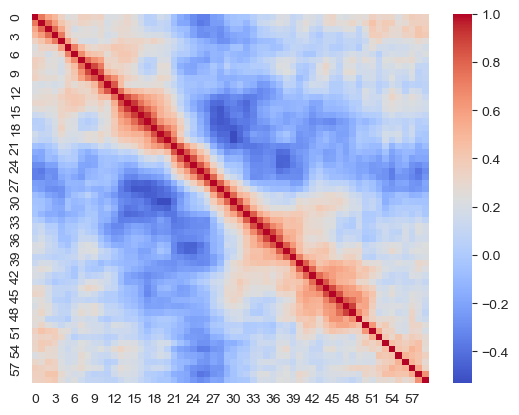

In [8]:
sns.heatmap(df.select(cs.exclude('Label')).corr(), cmap='coolwarm')

**TASK: What are the top 5 correlated frequencies with the target\label?**

*Note: You many need to map the label to 0s and 1s.*

*Additional Note: We're looking for **absolute** correlation values.*

In [33]:
#CODE HERE
df = df.with_columns(
    pl.col('Label').map_elements(
        lambda label: 1 if label == 'M' else 0, return_dtype=pl.UInt8).alias('Target Label')
)


In [39]:
target_label = np.abs(df.select(cs.numeric()).corr().sort('Target Label')['Target Label']).tail(5)

feature_names = target_label.name

pl.DataFrame({'Correlation': target_label}).with_columns(pl.lit(feature_names).alias('Feature'))

Correlation,Feature
f64,str
0.341142,"""Target Label"""
0.351312,"""Target Label"""
0.392245,"""Target Label"""
0.432855,"""Target Label"""
1.0,"""Target Label"""


## Train | Test Split

Our approach here will be one of using Cross Validation on 90% of the dataset, and then judging our results on a final test set of 10% to evaluate our model.

**TASK: Split the data into features and labels, and then split into a training set and test set, with 90% for Cross-Validation training, and 10% for a final test set.**

*Note: The solution uses a random_state=42*

In [43]:
# CODE HERE
X = df.select(cs.exclude(['Label', 'Target Label']))
y = df.select('Target Label')

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**TASK: Create a PipeLine that contains both a StandardScaler and a KNN model**

In [45]:
# CODE HERE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

pipeline = Pipeline([('scaler', scaler), ('knn', knn_model)])

**TASK: Perform a grid-search with the pipeline to test various values of k and report back the best performing parameters.**

In [48]:
# CODE HERE
from sklearn.model_selection import GridSearchCV

param_grid = {'knn__n_neighbors': range(1, 30)}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [49]:
grid_search.fit(X_train, y_train)

C:\Users\Zygim\anaconda3\envs\Analytic\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1,
                                                             n_neighbors=29))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 30)},
             scoring='accuracy')

In [54]:
grid_search.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_jobs=-1, n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_jobs=-1, n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': -1,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

**(HARD) TASK: Using the .cv_results_ dictionary, see if you can create a plot of the mean test scores per K value.**

In [113]:
#CODE HERE

In [61]:
pl.DataFrame(grid_search.cv_results_['mean_test_score'])

column_0
f64
0.845377
0.834851
0.775249
0.764865
0.759317
…
0.68478
0.668848
0.674111


array([0.84537696, 0.78065434, 0.77524893, 0.75917496, 0.75931721,
       0.74822191, 0.75945946, 0.71664296, 0.7113798 , 0.68421053,
       0.70042674, 0.68435277, 0.68449502, 0.67908962, 0.69530583,
       0.68990043, 0.7113798 , 0.70042674, 0.72204836, 0.67908962,
       0.70071124, 0.69530583, 0.69530583, 0.68463727, 0.68477952,
       0.67923186, 0.67411095, 0.65775249, 0.6685633 ])

Text(0, 0.5, 'Accuracy')

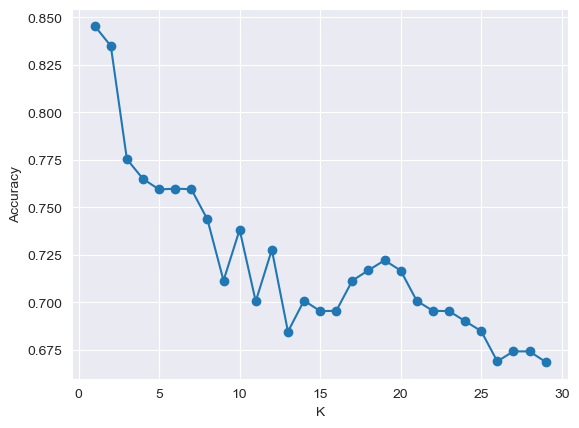

In [63]:
scores = grid_search.cv_results_['mean_test_score']
plt.plot(range(1, 30), scores, 'o-')
plt.xlabel('K')
plt.ylabel('Accuracy')

### Final Model Evaluation

**TASK: Using the grid classifier object from the previous step, get a final performance classification report and confusion matrix.**

In [64]:
#Code Here
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [65]:
predict = grid_search.predict(X_test)

In [69]:
labels = ['R', 'M']

In [71]:
confusion_matrix(y_test, predict)

array([[ 7,  1],
       [ 1, 12]], dtype=int64)

In [73]:
print(classification_report(y_test, predict, target_names=labels))

              precision    recall  f1-score   support

           R       0.88      0.88      0.88         8
           M       0.92      0.92      0.92        13

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



Text(0.5, 1.0, 'Confusion Matrix')

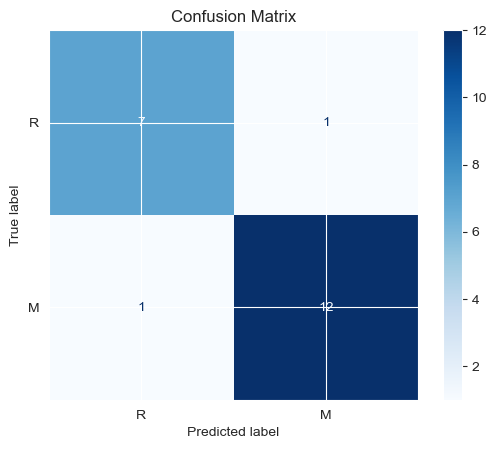

In [74]:
ConfusionMatrixDisplay.from_predictions(y_test, predict, cmap='Blues', display_labels=labels).ax_.set_title('Confusion Matrix')

### Great Job!